In [1]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr


In [2]:
from glob import glob
import librosa
# Updated code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='../speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = '../speech-emotion-recognition-ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24',
 'clean_speech']

1439

In [4]:
# #Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
# #is less strong for large chunk of files , so used Error Handling , where when it is not be able to 
# #produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
# import speech_recognition as sr
# r=sr.Recognizer()
# for file in range(0 , len(listOfFiles) , 1):
#     with sr.AudioFile(listOfFiles[file]) as source:
#         audio = r.listen(source)
#         try:
#             text = r.recognize_google(audio)
#             print(text)
#         except:
#             print('error')

In [5]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [6]:
# #Plotting the Basic Graphs for understanding of Audio Files :
# for file in range(0 , len(listOfFiles) , 1):
#     audio , sfreq = lr.load(listOfFiles[file])
#     time = np.arange(0 , len(audio)) / sfreq
    
#     fig ,ax = plt.subplots()
#     ax.plot(time , audio)
#     ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
#     plt.show()
    
# #PLOT THE SEPCTOGRAM
# for file in range(0 , len(listOfFiles) , 1):
#      sample_rate , samples = wavfile.read(listOfFiles[file])
#      frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
#      plt.pcolormesh(times, frequencies, spectrogram)
#      plt.imshow(spectrogram)
#      plt.ylabel('Frequency [Hz]')
#      plt.xlabel('Time [sec]')
#      plt.show()

In [7]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [8]:
# # Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . 
# import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
# from scipy.fftpack import fft
# import numpy as np
# for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wav.read(listOfFiles[file])
#     fft_out = fft(data)
#     %matplotlib inline
#     plt.plot(data, np.abs(fft_out))
#     plt.show()
    
# signals={}
# fft={}
# fbank={}
# mfccs={}
# # load data
# for file in range(0 , len(listOfFiles) , 1):
# #     rate, data = wavfile.read(listOfFiles[file])
#      signal,rate =librosa.load(listOfFiles[file] , sr=44100)
#      mask = envelope(signal , rate , 0.0005)
#      signals[file] = signal
#      fft[file] = calc_fft(signal , rate)
    
#      bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
#      fbank[file] = bank
#      mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
#      mfccs[file]=mel

# plot_signals(signals)
# plt.show()

# plot_fft(fft)
# plt.show()

# plot_fbank(fbank)
# plt.show()

# plot_mfccs(mfccs)
# plt.show()

In [9]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [10]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob(r'D:\SDGPFinalRepo\sdgpprojectv2\SpeechAnalysis\speech-emotion-recognition-ravdess-data\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'D:\SDGPFinalRepo\sdgpprojectv2\SpeechAnalysis\clean_speech\\'+str(file_name), rate=rate,data=signal[mask])

  0%|          | 0/1439 [00:00<?, ?it/s]

100%|██████████| 1439/1439 [00:24<00:00, 58.96it/s]


In [11]:
# Function to extract features from an audio file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result

In [12]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions INternova wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust','neutral','angry','surprised']

In [13]:
# Function to load data
def load_data(test_size=0.33):
    x, y = [], []
    for file in glob.glob(r'D:\SDGPFinalRepo\sdgpprojectv2\SpeechAnalysis\clean_speech\\*.wav'):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion, file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [14]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))
y_test_map = np.array(y_test).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_train).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(935, 180) (312, 180) (935, 2) (312, 2)
(935,) (312,)
03-01-05-01-01-01-11.wav
03-01-07-01-02-01-13.wav
03-01-03-02-01-01-16.wav
03-01-07-01-02-02-16.wav
03-01-03-01-01-02-16.wav
03-01-08-01-02-01-03.wav
03-01-01-01-02-01-11.wav
03-01-05-01-02-02-11.wav
03-01-05-01-01-02-05.wav
03-01-01-01-01-02-05.wav
03-01-07-02-01-02-12.wav
03-01-03-01-02-02-18.wav
03-01-07-02-02-02-03.wav
03-01-08-02-02-02-24.wav
03-01-06-02-01-01-11.wav
03-01-03-01-01-02-22.wav
03-01-07-02-02-02-11.wav
03-01-03-01-02-01-03.wav
03-01-01-01-01-02-23.wav
03-01-03-02-01-02-03.wav
03-01-05-01-01-01-07.wav
03-01-01-01-01-02-17.wav
03-01-07-02-01-01-23.wav
03-01-07-01-01-02-04.wav
03-01-08-02-02-02-06.wav
03-01-05-02-01-01-18.wav
03-01-01-01-02-01-13.wav
03-01-01-01-01-01-23.wav
03-01-07-02-02-02-10.wav
03-01-05-02-02-02-02.wav
03-01-02-02-02-02-09.wav
03-01-07-02-02-02-18.wav
03-01-02-02-02-02-18.wav
03-01-01-01-01-01-07.wav
03-01-06-01-02-02-21.wav
03-01-02-01-01-01-08.wav
03-01-02-01-02-01-06.wav
03-01-02-01-01-02-12.

In [15]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-3.67754913e+02,  5.15162163e+01, -1.44783592e+01,  1.03217611e+01,
       -1.26336432e+01,  5.91780949e+00, -1.12973728e+01, -1.59726667e+01,
       -1.56751356e+01, -1.32658892e+01, -1.14414244e+01, -6.74579906e+00,
       -7.28524590e+00, -3.80904913e+00, -1.03727150e+01, -8.91137791e+00,
       -3.17859721e+00, -1.11112881e+00, -5.87971091e-01,  8.46002996e-01,
        2.86473370e+00,  4.35003614e+00, -2.60465384e-01,  4.05364943e+00,
        5.94463825e+00,  9.96228409e+00,  7.95457983e+00,  2.97736859e+00,
        6.27451563e+00,  4.84362543e-01,  4.19561177e-01,  2.20835161e+00,
       -1.19798994e+00, -2.22397923e-01, -3.54365373e+00, -2.73042440e+00,
       -4.40739822e+00,  1.17877150e+00,  1.28510308e+00,  5.63405693e-01,
        5.46813667e-01,  5.19055188e-01,  5.19725442e-01,  5.82563818e-01,
        5.40345311e-01,  4.90828484e-01,  5.12844920e-01,  5.93833506e-01,
        5.85244358e-01,  5.71851254e-01,  6.37773216e-01,  5.63301206e-01,
        6.11834554e-03, 

In [16]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [17]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [18]:
#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [19]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [20]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['disgust', 'disgust', 'fearful', 'surprised', 'fearful',
       'surprised', 'calm', 'disgust', 'angry', 'calm', 'happy',
       'surprised', 'disgust', 'surprised', 'angry', 'happy', 'disgust',
       'happy', 'happy', 'angry', 'fearful', 'neutral', 'angry',
       'disgust', 'surprised', 'angry', 'calm', 'neutral', 'happy',
       'angry', 'calm', 'happy', 'calm', 'fearful', 'surprised', 'calm',
       'calm', 'calm', 'fearful', 'fearful', 'surprised', 'neutral',
       'angry', 'calm', 'disgust', 'surprised', 'surprised', 'happy',
       'calm', 'happy', 'angry', 'calm', 'angry', 'fearful', 'fearful',
       'calm', 'happy', 'surprised', 'angry', 'happy', 'fearful',
       'neutral', 'angry', 'angry', 'surprised', 'calm', 'happy', 'angry',
       'angry', 'calm', 'calm', 'disgust', 'disgust', 'disgust', 'calm',
       'surprised', 'calm', 'fearful', 'calm', 'surprised', 'happy',
       'angry', 'surprised', 'happy', 'surprised', 'calm', 'surprised',
       'fearful', 'fearful

In [21]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0       disgust  03-01-05-01-01-01-11.wav
1       disgust  03-01-07-01-02-01-13.wav
2       fearful  03-01-03-02-01-01-16.wav
3     surprised  03-01-07-01-02-02-16.wav
4       fearful  03-01-03-01-01-02-16.wav
..          ...                       ...
307     fearful  03-01-06-01-02-02-14.wav
308       angry  03-01-05-02-01-01-20.wav
309     disgust  03-01-07-02-01-02-21.wav
310     disgust  03-01-07-02-02-02-21.wav
311       angry  03-01-05-02-02-02-20.wav

[312 rows x 2 columns]


In [22]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 1 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


<Figure size 1500x500 with 0 Axes>

Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Amplitude')

Text(0.5, 1.0, 'Waveform')

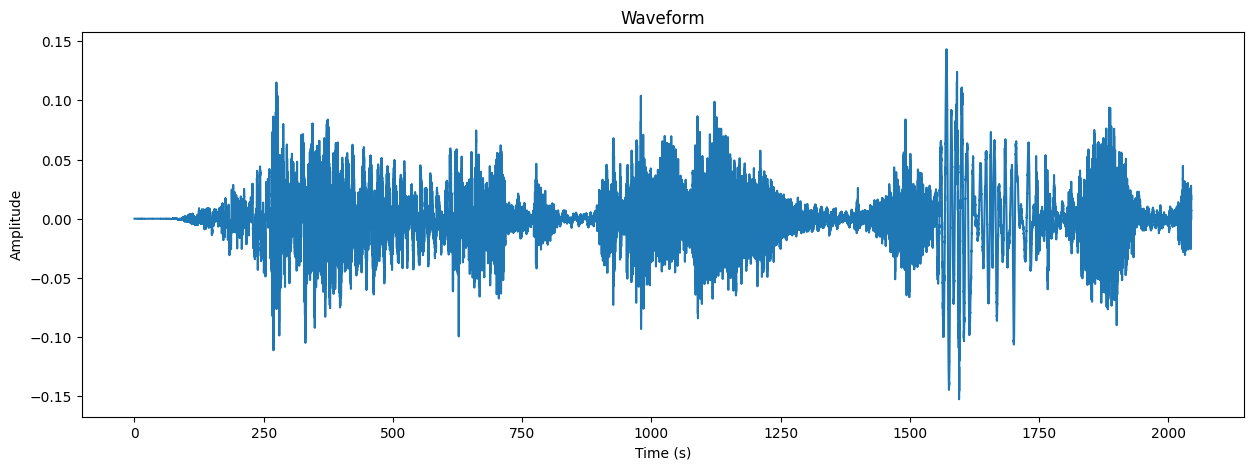

In [23]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file and sampling rate
data, sampling_rate = librosa.load('output10.wav')

# Create the time axis
time = librosa.times_like(data, sr=sampling_rate)

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()


In [24]:
file = 'output10.wav'

# Extract features from the audio file
new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True)

# Reshape the feature array to match the input format expected by the model
new_feature = new_feature.reshape(1, -1)

# Predict the emotion using the model
predicted_emotion = Emotion_Voice_Detection_Model.predict(new_feature)

# Print the predicted emotion
print("Predicted Emotion:", predicted_emotion)


Predicted Emotion: ['happy']


In [25]:
import pyaudio
import wave
import numpy as np
import librosa

def record_audio(output_filename, duration):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = duration
    WAVE_OUTPUT_FILENAME = output_filename

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

def predict_emotions(audio_file):
    data, sampling_rate = librosa.load(audio_file)
    duration = librosa.get_duration(y=data, sr=sampling_rate)

    # Split the audio into chunks of 4 seconds
    chunk_duration = 4
    num_chunks = int(np.ceil(duration / chunk_duration))

    emotions = []

    for i in range(num_chunks):
        start = i * chunk_duration
        end = min((i + 1) * chunk_duration, duration)

        # Extract features from the entire audio file
        chunk_features = extract_feature(audio_file, mfcc=True, chroma=True, mel=True)

        # Reshape the feature array to match the input format expected by the model
        chunk_features = chunk_features.reshape(1, -1)

        # Predict the emotion using the model
        predicted_emotion = Emotion_Voice_Detection_Model.predict(chunk_features)

        # Add the predicted emotion to the list
        emotions.append(predicted_emotion)

    return emotions

# Example usage
output_filename = 'output.wav'
record_duration = 8  # Recording duration in seconds
record_audio(output_filename, record_duration)

# Predict emotions from the recorded audio
predicted_emotions = predict_emotions(output_filename)
print("Predicted Emotions:", predicted_emotions)

* recording
* done recording
Predicted Emotions: [array(['fearful'], dtype='<U9'), array(['fearful'], dtype='<U9')]
